In [1]:
from jax import jit, grad, vmap, random
from functools import partial
import jax
import jax.numpy as np
from jax.experimental import stax # neural network library
from jax.experimental.stax import GeneralConv, Conv, ConvTranspose, Dense, MaxPool, Relu, Flatten, LogSoftmax, LeakyRelu, Dropout, Tanh, Sigmoid, BatchNorm # neural network layers
from jax.nn import softmax, sigmoid
from jax.nn.initializers import zeros
import matplotlib.pyplot as plt # visualization
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays
from jax.ops import index, index_add, index_update
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import gym

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

In [3]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = onp.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

In [4]:
train_episodes = 1000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

rng = random.PRNGKey(1)

/Users/anirbanlaha/dev/dec19/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

In [6]:
#Define Q-network
class QNetwork:
    def __init__(self, rng, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        self.init_fun, self.apply_fun = stax.serial(
            Dense(hidden_size), Dense(hidden_size), Dense(action_size)
        )
        self.in_shape = (-1, state_size)
        _, self.net_params = self.init_fun(rng, self.in_shape)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(step_size=learning_rate)
        self.opt_state = self.opt_init(self.net_params)

    def output(self, inputs):
        return self.apply_fun(self.net_params, inputs)

    def loss_fun(self, params, inputs, actions, targets):
        output = self.apply_fun(self.net_params, inputs)
        selectedq = np.sum(actions*output, axis=-1)
        # print(inputs.shape, actions.shape, output.shape, selectedq.shape, targets.shape)
        return np.mean(np.square(-targets))

    def step(self, i, inputs, actions, targets):
        params = self.get_params(self.opt_state)
        g=grad(self.loss_fun)(params, inputs, actions, targets)
        self.loss = self.loss_fun(params, inputs, actions, targets)
        self.opt_state = self.opt_update(i, g, self.opt_state)
        self.net_params = self.get_params(self.opt_state)
        
mainQN = QNetwork(rng, name='main', hidden_size=hidden_size, learning_rate=learning_rate)

In [15]:
# Now train with experiences
rewards_list = []
def one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)

    
step = 0
for ep in range(1, train_episodes):
    total_reward = 0
    t = 0
    while t < max_steps:
        step += 1
        # Uncomment this next line to watch the training
        env.render() 
        
        # Explore or Exploit
        explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
        if explore_p > random.uniform(rng):
            # Make a random action
            action = env.action_space.sample()
        else:
            # Get action from Q-network
            Qs = mainQN.output(state)
            action = np.argmax(Qs)
        
        # Take action, get new state and reward
        next_state, reward, done, _ = env.step(action)

        total_reward += reward
        
        if done:
            # the episode ends so no next state
            next_state = np.zeros(state.shape)
            t = max_steps
            
            print('Episode: {}'.format(ep),
                    'Total reward: {}'.format(total_reward),
                    'Training loss: {:.4f}'.format(loss),
                    'Explore P: {:.4f}'.format(explore_p))
            rewards_list.append((ep, total_reward))
            
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            
            # Start new episode
            env.reset()
            # Take one random step to get the pole and cart moving
            state, reward, done, _ = env.step(env.action_space.sample())

        else:
            # Add experience to memory
            memory.add((state, action, reward, next_state))
            state = next_state
            t += 1
        
        # Sample mini-batch from memory
        batch = memory.sample(batch_size)
        states = np.array([each[0] for each in batch])
        actions = one_hot(np.array([each[1] for each in batch]), 2)
        rewards = np.array([each[2] for each in batch])
        next_states = np.array([each[3] for each in batch])
        
        # Train network
        target_Qs = mainQN.output(next_states)
        
        # Set target_Qs to 0 for states where episode ends
        episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
        new_target_Qs = index_update(target_Qs, index[episode_ends], (0, 0))
        target_Qs = new_target_Qs
        
        targets = rewards + gamma * np.max(target_Qs, axis=1)
        # print(states.shape, targets.shape, targets)
        mainQN.step((ep-1)*train_episodes+step-1, states, actions, targets)

        loss = mainQN.loss


Episode: 1 Total reward: 22.0 Training loss: 1.1730 Explore P: 0.9978
Episode: 2 Total reward: 43.0 Training loss: 1.1388 Explore P: 0.9936
Episode: 3 Total reward: 65.0 Training loss: 1.1241 Explore P: 0.9872
Episode: 4 Total reward: 18.0 Training loss: 1.1659 Explore P: 0.9855
Episode: 5 Total reward: 20.0 Training loss: 1.1114 Explore P: 0.9835
Episode: 6 Total reward: 23.0 Training loss: 1.1576 Explore P: 0.9813
Episode: 7 Total reward: 11.0 Training loss: 1.1776 Explore P: 0.9802
Episode: 8 Total reward: 30.0 Training loss: 1.1113 Explore P: 0.9773
Episode: 9 Total reward: 8.0 Training loss: 1.1461 Explore P: 0.9765
Episode: 10 Total reward: 16.0 Training loss: 1.1765 Explore P: 0.9750
Episode: 11 Total reward: 11.0 Training loss: 1.1524 Explore P: 0.9739
Episode: 12 Total reward: 10.0 Training loss: 1.1148 Explore P: 0.9730
Episode: 13 Total reward: 43.0 Training loss: 1.0718 Explore P: 0.9688
Episode: 14 Total reward: 31.0 Training loss: 1.0801 Explore P: 0.9659
Episode: 15 Tota

Episode: 117 Total reward: 24.0 Training loss: 1.1780 Explore P: 0.7762
Episode: 118 Total reward: 7.0 Training loss: 1.2102 Explore P: 0.7756
Episode: 119 Total reward: 11.0 Training loss: 1.2248 Explore P: 0.7748
Episode: 120 Total reward: 19.0 Training loss: 1.1147 Explore P: 0.7733
Episode: 121 Total reward: 15.0 Training loss: 1.0843 Explore P: 0.7722
Episode: 122 Total reward: 23.0 Training loss: 1.1785 Explore P: 0.7704
Episode: 123 Total reward: 37.0 Training loss: 1.1449 Explore P: 0.7676
Episode: 124 Total reward: 32.0 Training loss: 1.1811 Explore P: 0.7652
Episode: 125 Total reward: 24.0 Training loss: 1.2642 Explore P: 0.7634
Episode: 126 Total reward: 21.0 Training loss: 1.1371 Explore P: 0.7618
Episode: 127 Total reward: 18.0 Training loss: 1.1361 Explore P: 0.7605
Episode: 128 Total reward: 21.0 Training loss: 1.2452 Explore P: 0.7589
Episode: 129 Total reward: 21.0 Training loss: 1.1395 Explore P: 0.7573
Episode: 130 Total reward: 30.0 Training loss: 1.0917 Explore P: 

Episode: 231 Total reward: 18.0 Training loss: 1.2020 Explore P: 0.6072
Episode: 232 Total reward: 19.0 Training loss: 1.1745 Explore P: 0.6061
Episode: 233 Total reward: 51.0 Training loss: 1.1860 Explore P: 0.6031
Episode: 234 Total reward: 13.0 Training loss: 1.1596 Explore P: 0.6023
Episode: 235 Total reward: 15.0 Training loss: 1.1936 Explore P: 0.6014
Episode: 236 Total reward: 38.0 Training loss: 1.1457 Explore P: 0.5992
Episode: 237 Total reward: 12.0 Training loss: 1.1859 Explore P: 0.5985
Episode: 238 Total reward: 20.0 Training loss: 1.1176 Explore P: 0.5973
Episode: 239 Total reward: 13.0 Training loss: 1.1323 Explore P: 0.5965
Episode: 240 Total reward: 22.0 Training loss: 1.1077 Explore P: 0.5952
Episode: 241 Total reward: 10.0 Training loss: 1.0715 Explore P: 0.5946
Episode: 242 Total reward: 19.0 Training loss: 1.1038 Explore P: 0.5935
Episode: 243 Total reward: 14.0 Training loss: 1.0971 Explore P: 0.5927
Episode: 244 Total reward: 44.0 Training loss: 1.1119 Explore P:

Episode: 345 Total reward: 16.0 Training loss: 1.1797 Explore P: 0.4719
Episode: 346 Total reward: 29.0 Training loss: 1.1162 Explore P: 0.4705
Episode: 347 Total reward: 9.0 Training loss: 1.0555 Explore P: 0.4701
Episode: 348 Total reward: 32.0 Training loss: 1.2392 Explore P: 0.4687
Episode: 349 Total reward: 12.0 Training loss: 1.1439 Explore P: 0.4681
Episode: 350 Total reward: 9.0 Training loss: 1.1240 Explore P: 0.4677
Episode: 351 Total reward: 21.0 Training loss: 1.1375 Explore P: 0.4667
Episode: 352 Total reward: 34.0 Training loss: 1.1509 Explore P: 0.4652
Episode: 353 Total reward: 12.0 Training loss: 1.1064 Explore P: 0.4646
Episode: 354 Total reward: 28.0 Training loss: 1.1432 Explore P: 0.4634
Episode: 355 Total reward: 18.0 Training loss: 1.1203 Explore P: 0.4626
Episode: 356 Total reward: 12.0 Training loss: 1.1871 Explore P: 0.4620
Episode: 357 Total reward: 23.0 Training loss: 1.0928 Explore P: 0.4610
Episode: 358 Total reward: 17.0 Training loss: 1.2149 Explore P: 0

Episode: 459 Total reward: 12.0 Training loss: 1.1833 Explore P: 0.3727
Episode: 460 Total reward: 14.0 Training loss: 1.2078 Explore P: 0.3722
Episode: 461 Total reward: 66.0 Training loss: 1.2213 Explore P: 0.3698
Episode: 462 Total reward: 30.0 Training loss: 1.1800 Explore P: 0.3687
Episode: 463 Total reward: 18.0 Training loss: 1.1773 Explore P: 0.3681
Episode: 464 Total reward: 31.0 Training loss: 1.1803 Explore P: 0.3670
Episode: 465 Total reward: 10.0 Training loss: 1.1614 Explore P: 0.3666
Episode: 466 Total reward: 13.0 Training loss: 1.2008 Explore P: 0.3662
Episode: 467 Total reward: 34.0 Training loss: 1.2039 Explore P: 0.3650
Episode: 468 Total reward: 32.0 Training loss: 1.1841 Explore P: 0.3638
Episode: 469 Total reward: 18.0 Training loss: 1.1705 Explore P: 0.3632
Episode: 470 Total reward: 8.0 Training loss: 1.0949 Explore P: 0.3629
Episode: 471 Total reward: 30.0 Training loss: 1.1438 Explore P: 0.3618
Episode: 472 Total reward: 23.0 Training loss: 1.1989 Explore P: 

Episode: 573 Total reward: 28.0 Training loss: 1.1847 Explore P: 0.2924
Episode: 574 Total reward: 13.0 Training loss: 1.1196 Explore P: 0.2920
Episode: 575 Total reward: 22.0 Training loss: 1.0778 Explore P: 0.2914
Episode: 576 Total reward: 19.0 Training loss: 1.0691 Explore P: 0.2908
Episode: 577 Total reward: 12.0 Training loss: 1.1798 Explore P: 0.2905
Episode: 578 Total reward: 8.0 Training loss: 1.1817 Explore P: 0.2903
Episode: 579 Total reward: 12.0 Training loss: 1.1331 Explore P: 0.2899
Episode: 580 Total reward: 24.0 Training loss: 1.1711 Explore P: 0.2893
Episode: 581 Total reward: 42.0 Training loss: 1.2059 Explore P: 0.2881
Episode: 582 Total reward: 18.0 Training loss: 1.1513 Explore P: 0.2876
Episode: 583 Total reward: 16.0 Training loss: 1.2108 Explore P: 0.2872
Episode: 584 Total reward: 27.0 Training loss: 1.1526 Explore P: 0.2864
Episode: 585 Total reward: 21.0 Training loss: 1.0761 Explore P: 0.2858
Episode: 586 Total reward: 21.0 Training loss: 1.1684 Explore P: 

Episode: 687 Total reward: 23.0 Training loss: 1.1118 Explore P: 0.2317
Episode: 688 Total reward: 22.0 Training loss: 1.1801 Explore P: 0.2312
Episode: 689 Total reward: 26.0 Training loss: 1.1648 Explore P: 0.2306
Episode: 690 Total reward: 24.0 Training loss: 1.1932 Explore P: 0.2301
Episode: 691 Total reward: 15.0 Training loss: 1.2321 Explore P: 0.2298
Episode: 692 Total reward: 25.0 Training loss: 1.1189 Explore P: 0.2292
Episode: 693 Total reward: 13.0 Training loss: 1.0413 Explore P: 0.2289
Episode: 694 Total reward: 16.0 Training loss: 1.1250 Explore P: 0.2286
Episode: 695 Total reward: 14.0 Training loss: 1.0994 Explore P: 0.2283
Episode: 696 Total reward: 16.0 Training loss: 1.2264 Explore P: 0.2279
Episode: 697 Total reward: 39.0 Training loss: 1.0853 Explore P: 0.2271
Episode: 698 Total reward: 21.0 Training loss: 1.1421 Explore P: 0.2266
Episode: 699 Total reward: 21.0 Training loss: 1.2263 Explore P: 0.2262
Episode: 700 Total reward: 10.0 Training loss: 1.1824 Explore P:

Episode: 801 Total reward: 20.0 Training loss: 1.1263 Explore P: 0.1822
Episode: 802 Total reward: 19.0 Training loss: 1.0866 Explore P: 0.1819
Episode: 803 Total reward: 13.0 Training loss: 1.1685 Explore P: 0.1817
Episode: 804 Total reward: 28.0 Training loss: 1.2080 Explore P: 0.1812
Episode: 805 Total reward: 10.0 Training loss: 1.2001 Explore P: 0.1810
Episode: 806 Total reward: 14.0 Training loss: 1.1467 Explore P: 0.1808
Episode: 807 Total reward: 9.0 Training loss: 1.1831 Explore P: 0.1806
Episode: 808 Total reward: 12.0 Training loss: 1.1575 Explore P: 0.1804
Episode: 809 Total reward: 18.0 Training loss: 1.2286 Explore P: 0.1801
Episode: 810 Total reward: 15.0 Training loss: 1.1942 Explore P: 0.1798
Episode: 811 Total reward: 29.0 Training loss: 1.1451 Explore P: 0.1794
Episode: 812 Total reward: 20.0 Training loss: 1.1278 Explore P: 0.1790
Episode: 813 Total reward: 23.0 Training loss: 1.1559 Explore P: 0.1786
Episode: 814 Total reward: 20.0 Training loss: 1.2049 Explore P: 

Episode: 915 Total reward: 40.0 Training loss: 1.1025 Explore P: 0.1420
Episode: 916 Total reward: 32.0 Training loss: 1.2342 Explore P: 0.1416
Episode: 917 Total reward: 32.0 Training loss: 1.1960 Explore P: 0.1411
Episode: 918 Total reward: 12.0 Training loss: 1.1192 Explore P: 0.1410
Episode: 919 Total reward: 30.0 Training loss: 1.1879 Explore P: 0.1406
Episode: 920 Total reward: 18.0 Training loss: 1.1154 Explore P: 0.1403
Episode: 921 Total reward: 28.0 Training loss: 1.0539 Explore P: 0.1400
Episode: 922 Total reward: 9.0 Training loss: 1.1583 Explore P: 0.1399
Episode: 923 Total reward: 44.0 Training loss: 1.1532 Explore P: 0.1393
Episode: 924 Total reward: 15.0 Training loss: 1.1215 Explore P: 0.1391
Episode: 925 Total reward: 15.0 Training loss: 1.1846 Explore P: 0.1389
Episode: 926 Total reward: 12.0 Training loss: 1.1881 Explore P: 0.1388
Episode: 927 Total reward: 9.0 Training loss: 1.1802 Explore P: 0.1386
Episode: 928 Total reward: 14.0 Training loss: 1.1615 Explore P: 0

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = onp.cumsum(onp.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total Reward')

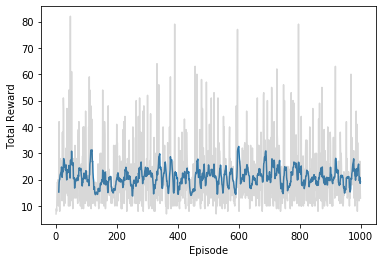

In [13]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [14]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

NameError: name 'tf' is not defined

In [ ]:
env.close()